Health Insurance Dataset

Task:
- Build a model that predicts "charges" for a given person based on their features.
- Evaluate the quality of your model.
- Identify the factors with the highest impact.

Expected result - link to a GitHub repo with:
- Code for the solution (any programming language, Python or R preferred).
- Brief summary of the solution*: what did you do, which steps did you make, how to interpret the results.

* Both code and solution can be a single report file, e.g. .ipynb or .rmd

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

In [2]:
insurance = pd.read_csv("insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
X = insurance.drop(columns=['charges'])
y = insurance['charges']
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


### Original charges 

(array([536., 398., 129.,  86.,  35.,  59.,  57.,  32.,   2.,   4.]),
 array([ 1121.8739  ,  7386.729311, 13651.584722, 19916.440133,
        26181.295544, 32446.150955, 38711.006366, 44975.861777,
        51240.717188, 57505.572599, 63770.42801 ]),
 <a list of 10 Patch objects>)

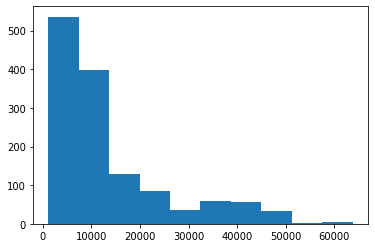

In [4]:
plt.hist(y)

### Log charges

(array([ 46., 105., 101., 155., 198., 283., 156., 123., 115.,  56.]),
 array([ 7.02275569,  7.42678461,  7.83081352,  8.23484244,  8.63887136,
         9.04290027,  9.44692919,  9.8509581 , 10.25498702, 10.65901594,
        11.06304485]),
 <a list of 10 Patch objects>)

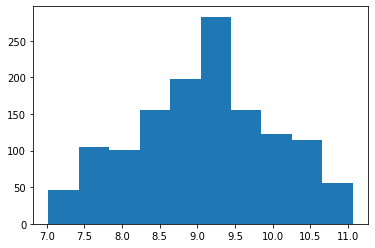

In [5]:
plt.hist(np.log(y))

We will predict log to reduce dispersion of predictions

## Preprocess
- one hot encoding of categorical features sex, children, smoker, region
- making one hot encoding of categories for thresholds age

Normalization of bmi we are going to do after splitting into train and test parts

### Age

(array([137.,  57.,  28.,  56.,  28.,  56.,  28.,  54.,  27.,  52.,  26.,
         50.,  25.,  50.,  27.,  54.,  54.,  29.,  58.,  29.,  57.,  29.,
         57.,  28.,  52.,  26.,  50.,  23.,  46.,  45.]),
 array([18.        , 19.53333333, 21.06666667, 22.6       , 24.13333333,
        25.66666667, 27.2       , 28.73333333, 30.26666667, 31.8       ,
        33.33333333, 34.86666667, 36.4       , 37.93333333, 39.46666667,
        41.        , 42.53333333, 44.06666667, 45.6       , 47.13333333,
        48.66666667, 50.2       , 51.73333333, 53.26666667, 54.8       ,
        56.33333333, 57.86666667, 59.4       , 60.93333333, 62.46666667,
        64.        ]),
 <a list of 30 Patch objects>)

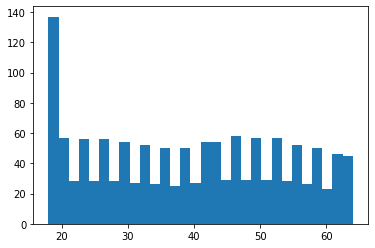

In [6]:
plt.hist(X['age'], bins=30)

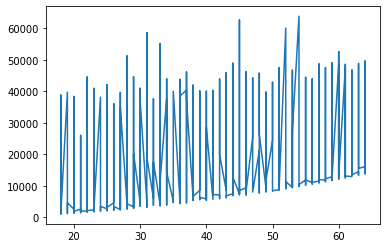

In [7]:
plt.plot(np.sort(X['age']), y[np.argsort(X['age'])])

We splitted column age into 30 bins and, as we see by the distribution on a histogram, after 20 the number of elements can be grouped to have pretty much same number of elements in one group. 
As we see on a plot, that shows how the charge changes as age changes, there is no big preponderance of charge in certain age - so we actually can set thresholds and split age into several groups to build categories.

(array([222., 140., 109., 128., 102., 137., 144., 114., 128., 114.]),
 array([18. , 22.6, 27.2, 31.8, 36.4, 41. , 45.6, 50.2, 54.8, 59.4, 64. ]),
 <a list of 10 Patch objects>)

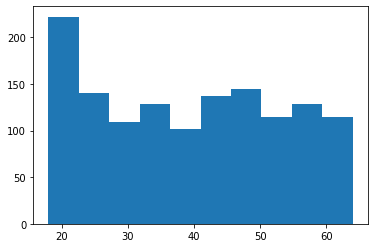

In [8]:
plt.hist(X['age'], bins=10)

As we see how the age distributed, when we split on 10 bins, approximately we can take around 5 years in a group.

In [9]:
X['less 20'] = np.float64(X['age'] < 20)
for year in range(20, 61, 5):
    X[f'{year}-{year + 5}'] = np.float64((year < X['age'].values) == (X['age'].values < year + 5))
X.head()

,age,sex,bmi,children,smoker,region,less 20,20-25,25-30,30-35,35-40,40-45,45-50,50-55,55-60,60-65
0,19,female,27.900,0,yes,southwest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18,male,33.770,1,no,southeast,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28,male,33.000,3,no,southeast,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33,male,22.705,0,no,northwest,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,32,male,28.880,0,no,northwest,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
print("length of age categories:\n", 
      {name_col : np.sum(X[name_col]) 
       for name_col in X.columns if '0' in name_col})

length of age categories:
 {'less 20': 137.0, '20-25': 112.0, '25-30': 111.0, '30-35': 105.0, '35-40': 100.0, '40-45': 108.0, '45-50': 115.0, '50-55': 114.0, '55-60': 102.0, '60-65': 91.0}


In [11]:
X = X.drop(columns='age')
X.head()

,sex,bmi,children,smoker,region,less 20,20-25,25-30,30-35,35-40,40-45,45-50,50-55,55-60,60-65
0,female,27.900,0,yes,southwest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,male,33.770,1,no,southeast,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,male,33.000,3,no,southeast,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,male,22.705,0,no,northwest,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,male,28.880,0,no,northwest,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sex, children, smoker, region - one hot encoding

In [12]:
from sklearn.preprocessing import OneHotEncoder

We are one hot encoding binary features with dropping one value not to have two features with negative correlation (equal to -1)

In [13]:
encoder_bin = OneHotEncoder(sparse=False, drop='first')
encoder_bin.fit(X[['sex', 'smoker']])

encoder_other = OneHotEncoder(sparse=False, drop=None)
encoder_other.fit(X[['children', 'region']])

transformed_bin = encoder_bin.transform(X[['sex', 'smoker']])
transformed_other = encoder_other.transform(X[['children', 'region']])

In [14]:
print(encoder_bin.get_feature_names(['sex', 'smoker']))
print(encoder_other.get_feature_names(['children', 'region']))

['sex_male' 'smoker_yes']
['children_0' 'children_1' 'children_2' 'children_3' 'children_4'
 'children_5' 'region_northeast' 'region_northwest' 'region_southeast'
 'region_southwest']


In [15]:
for i, name in enumerate(encoder_bin.get_feature_names(['sex', 'smoker'])):
    X[name] = transformed_bin[:, i]
    
for i, name in enumerate(encoder_other.get_feature_names(['children', 'region'])):
    X[name] = transformed_other[:, i]
    
X = X.drop(columns=['sex', 'children', 'smoker', 'region'])
X.head()

,bmi,less 20,20-25,25-30,30-35,35-40,40-45,45-50,50-55,55-60,...,children_0,children_1,children_2,children_3,children_4,children_5,region_northeast,region_northwest,region_southeast,region_southwest
0,27.900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,33.770,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,33.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,22.705,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28.880,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
print("number of 1s in categories:\n", 
      {name_col : np.sum(X[name_col]) 
       for name_col in X.columns if name_col != 'bmi'})

number of 1s in categories:
 {'less 20': 137.0, '20-25': 112.0, '25-30': 111.0, '30-35': 105.0, '35-40': 100.0, '40-45': 108.0, '45-50': 115.0, '50-55': 114.0, '55-60': 102.0, '60-65': 91.0, 'sex_male': 676.0, 'smoker_yes': 274.0, 'children_0': 574.0, 'children_1': 324.0, 'children_2': 240.0, 'children_3': 157.0, 'children_4': 25.0, 'children_5': 18.0, 'region_northeast': 324.0, 'region_northwest': 325.0, 'region_southeast': 364.0, 'region_southwest': 325.0}


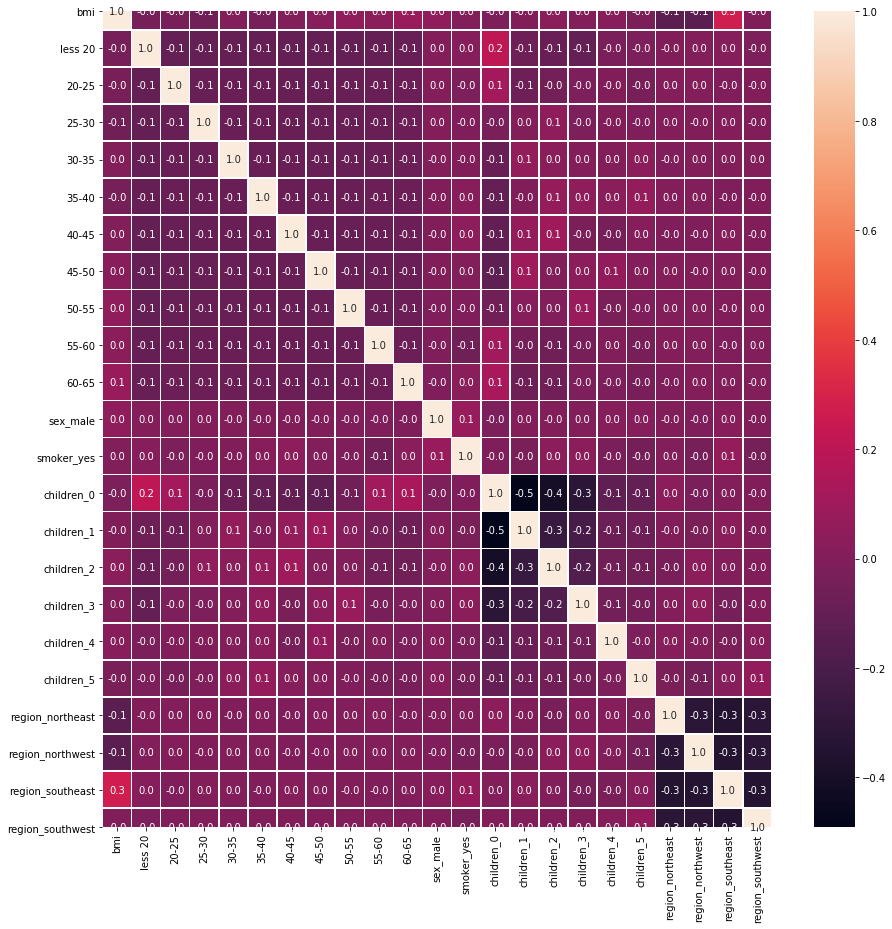

In [17]:
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Okay, so we don't have correlated features now

## Split 

In [18]:
from sklearn.model_selection import train_test_split

y_log = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.25, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4, shuffle=True)

print("length of train:", len(y_train), 
      "length of test:", len(y_test), 
      "length of val:", len(y_val))

length of train: 1003 length of test: 201 length of val: 134


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train.loc[:, 'bmi'] = scaler.fit_transform(X_train['bmi'][:, np.newaxis])
X_test.loc[:, 'bmi'] = scaler.transform(X_test['bmi'][:, np.newaxis])
X_val.loc[:, 'bmi'] = scaler.transform(X_val['bmi'][:, np.newaxis])

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [20]:
X_train.head()

,bmi,less 20,20-25,25-30,30-35,35-40,40-45,45-50,50-55,55-60,...,children_0,children_1,children_2,children_3,children_4,children_5,region_northeast,region_northwest,region_southeast,region_southwest
537,-0.104179,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.318303,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1132,1.530954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
722,1.063774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1067,1.916216,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [21]:
X_test.head()

,bmi,less 20,20-25,25-30,30-35,35-40,40-45,45-50,50-55,55-60,...,children_0,children_1,children_2,children_3,children_4,children_5,region_northeast,region_northwest,region_southeast,region_southwest
61,0.457087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
719,0.421400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
553,0.144011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
80,-0.641923,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
207,-0.503229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Making predictions

### Let's start with basic linear regression and see where it goes

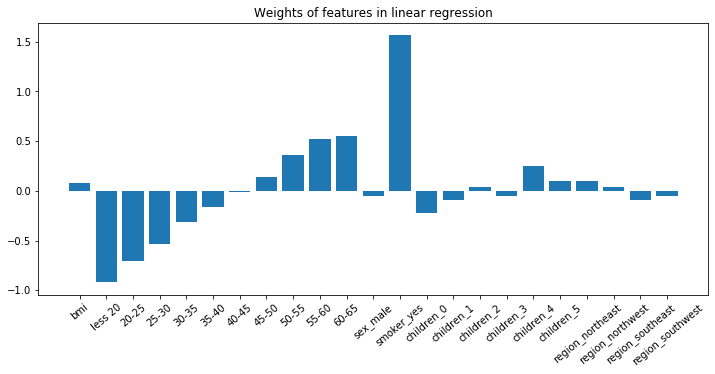

In [22]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)


plt.figure(figsize=(12, 5))

coef = linear_regression.coef_
x = range(len(coef))

plt.bar(x, coef)
plt.xticks(x, X.columns, rotation=40)
plt.title('Weights of features in linear regression')
plt.show()

In [23]:
lin_regr_feature_importance = X.columns[np.argsort(np.abs(linear_regression.coef_))[::-1]]

Evaluation 

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compute_errors(y_test, y_pred):
    print('MSE:', mean_squared_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('MAE:', mean_absolute_error(np.exp(y_test), np.exp(y_pred)))

    print('mean absolute relative_error:', 
          1 / len(y_test) * np.sum(np.abs(np.exp(y_pred) / np.exp(y_test) - 1) * 100), '%')

def errors_of_prediction(model, X_test, y_test=y_test):
    y_test_predicted = model.predict(X_test)
    compute_errors(y_test, y_test_predicted)

In [25]:
errors_of_prediction(linear_regression, X_test)

MSE: 65253518.22352159
RMSE: 8077.964980335183
MAE: 4671.964079955061
mean absolute relative_error: 37.015987523844935 %


As we see by weights, not all the features appear to be valuable in the linear regression model, let's try to improve the result by selecting most important ones.

#### Feature selection

In [26]:
from sklearn.feature_selection import RFECV

def feature_selection_estimation(model):
    rfecv = RFECV(estimator=model, step=1, cv=5)
    selector = rfecv.fit(X_train, y_train)
    
    scores = selector.grid_scores_
    plt.plot(range(len(scores)), scores)
    plt.xlabel('Количество')
    plt.ylabel('Качество на кросс-валидации')
    plt.show()
    
    print('filtered columns:', X.columns[rfecv.support_])
    print('deleted:', [col for col in X.columns if col not in X.columns[rfecv.support_]])
    
    X_train_filtered = selector.transform(X_train)
    X_test_filtered = selector.transform(X_test)


    model.fit(X_train_filtered, y_train)
    errors_of_prediction(model, X_test_filtered)

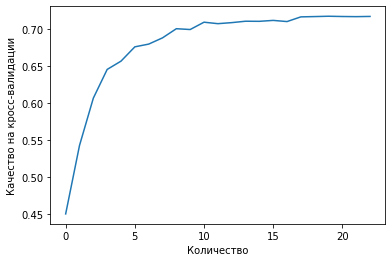

filtered columns: Index(['bmi', 'less 20', '20-25', '25-30', '30-35', '35-40', '45-50', '50-55',
       '55-60', '60-65', 'sex_male', 'smoker_yes', 'children_0', 'children_1',
       'children_3', 'children_4', 'children_5', 'region_northeast',
       'region_southeast', 'region_southwest'],
      dtype='object')
deleted: ['40-45', 'children_2', 'region_northwest']
MSE: 65105271.7696675
RMSE: 8068.783785036472
MAE: 4666.242664047965
mean absolute relative_error: 36.91474433546534 %


In [27]:
feature_selection_estimation(linear_regression)

Seems like for linear regression all the features are important as a result was slightly better for all the features

### Regression with random forest

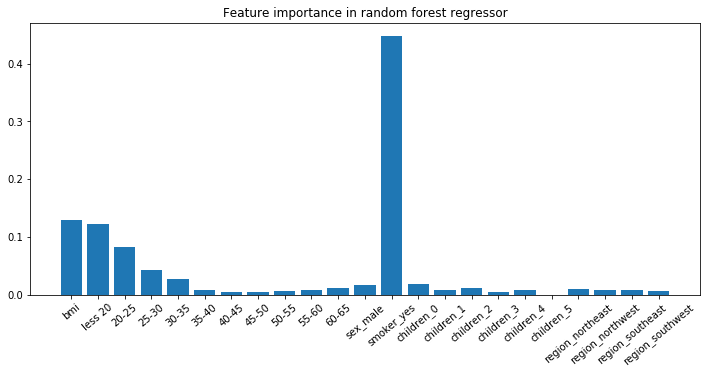

In [28]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(criterion='mse', n_estimators=15)
rf.fit(X_train, y_train)

plt.figure(figsize=(12, 5))

coef = rf.feature_importances_
x = range(len(coef))

plt.bar(x, coef)
plt.xticks(x, X.columns, rotation=40)
plt.title('Feature importance in random forest regressor')
plt.show()

In [29]:
errors_of_prediction(rf, X_test)

MSE: 32354221.645932168
RMSE: 5688.077148380828
MAE: 3326.3689068945146
mean absolute relative_error: 40.20706053702565 %


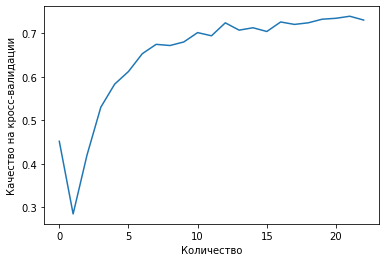

filtered columns: Index(['bmi', 'less 20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50',
       '50-55', '55-60', '60-65', 'sex_male', 'smoker_yes', 'children_0',
       'children_1', 'children_2', 'children_3', 'children_4',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'],
      dtype='object')
deleted: ['children_5']
MSE: 32870495.437950257
RMSE: 5733.279640655099
MAE: 3377.8063766587625
mean absolute relative_error: 38.52710682688683 %


In [30]:
feature_selection_estimation(rf)

Grid search best hyperparams for random forest

In [31]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

In [32]:
def search_best_hyperparams(estimator, params, X_train=X_train):
    searcher = RandomizedSearchCV(estimator=estimator, param_distributions=params, cv=5, n_iter=30)
    searcher.fit(X_train, y_train)
    
    return searcher.best_estimator_, searcher.best_params_

In [33]:
rf_best_estimator, rf_best_params = search_best_hyperparams(RandomForestRegressor(criterion='mse'), 
                                                      params={'n_estimators': range(10, 300, 10),
                                                              'max_depth': range(3, 12),
                                                              'max_leaf_nodes': range(10, 100, 5)})

print(rf_best_estimator)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=25,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=180,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [34]:
print('best params for random forest:', rf_best_params)

best params for random forest: {'n_estimators': 180, 'max_leaf_nodes': 25, 'max_depth': 9}


In [35]:
errors_of_prediction(rf_best_estimator, X_test)

MSE: 29578594.34317514
RMSE: 5438.620628723347
MAE: 3182.5367766894246
mean absolute relative_error: 33.521919749141965 %


In [36]:
rf_regr_feature_importance = X.columns[np.argsort(rf_best_estimator.feature_importances_)[::-1]]
pd.DataFrame(np.column_stack((lin_regr_feature_importance,
                              rf_regr_feature_importance)), columns=["lin regr",
                                                                     "rf regr"])

,lin regr,rf regr
0,smoker_yes,smoker_yes
1,less 20,less 20
2,20-25,20-25
3,60-65,bmi
4,25-30,25-30
5,55-60,30-35
6,50-55,60-65
7,30-35,children_0
8,children_4,55-60
9,children_0,50-55


### Stochastic Gradient Regressor

In [37]:
from sklearn.linear_model import SGDRegressor

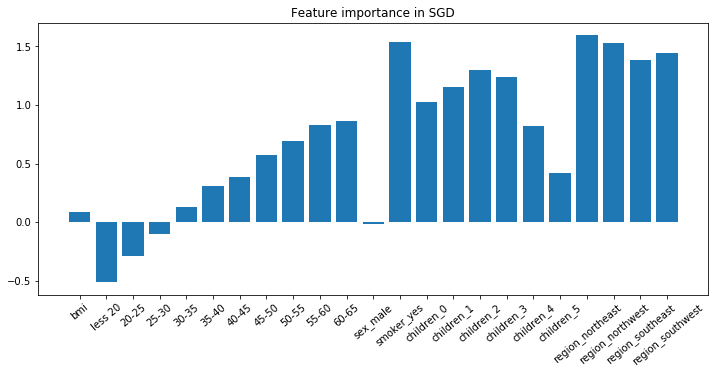

In [38]:
sgd = SGDRegressor()
sgd.fit(X_train, y_train)

plt.figure(figsize=(12, 5))
coef = sgd.coef_
x = range(len(coef))

plt.bar(x, coef)
plt.xticks(x, X.columns, rotation=40)
plt.title('Feature importance in SGD')
plt.show()

In [39]:
errors_of_prediction(sgd, X_test)

MSE: 66817980.514323145
RMSE: 8174.226600377748
MAE: 4917.9399367806145
mean absolute relative_error: 36.7340754448583 %


In [40]:
sgd_best_estimator, sgd_best_params = search_best_hyperparams(SGDRegressor(), 
                                                      params={'penalty': ['l2', 'l1', 'elasticnet'],
                                                              'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
                                                              'l1_ratio': np.arange(0, 1.1, 0.1),
                                                              'tol': [0.01, 0.001, 0.0001],
                                                              'learning_rate': ['constant',
                                                                                'optimal',
                                                                                'invscaling',
                                                                                'adaptive'],
                                                              'eta0': [0.0001, 0.001, 0.01, 0.1],
                                                              'power_t': [0.1, 0.25, 0.5, 0.7],
                                                              'early_stopping': [True]})

print('best model:', sgd_best_estimator)
print('best params for SGD:', sgd_best_params)
print('Results of evaluating the best SGD')
errors_of_prediction(sgd_best_estimator, X_test)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_mo

best model: SGDRegressor(alpha=0.001, average=False, early_stopping=True, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.2,
             learning_rate='adaptive', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='elasticnet', power_t=0.25,
             random_state=None, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)
best params for SGD: {'tol': 0.001, 'power_t': 0.25, 'penalty': 'elasticnet', 'learning_rate': 'adaptive', 'l1_ratio': 0.2, 'eta0': 0.1, 'early_stopping': True, 'alpha': 0.001}
Results of evaluating the best SGD
MSE: 66004021.272378854
RMSE: 8124.285893072624
MAE: 4729.710955337171
mean absolute relative_error: 37.30804677417759 %


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [41]:
sgd_regr_feature_importance = X.columns[np.argsort(sgd_best_estimator.coef_)[::-1]]
pd.DataFrame(np.column_stack((lin_regr_feature_importance,
                              rf_regr_feature_importance,
                              sgd_regr_feature_importance)), columns=["lin regr",
                                                                      "rf regr",
                                                                      "sgd regr"])

,lin regr,rf regr,sgd regr
0,smoker_yes,smoker_yes,smoker_yes
1,less 20,less 20,region_northeast
2,20-25,20-25,region_northwest
3,60-65,bmi,region_southwest
4,25-30,25-30,children_4
5,55-60,30-35,region_southeast
6,50-55,60-65,children_5
7,30-35,children_0,children_2
8,children_4,55-60,60-65
9,children_0,50-55,55-60


Surprisingly the method of stochastic gradient descent gives high importance to the categories showing regions and number of children. It would've been interesting to mix different models so they all give some impact to the result based on different features.

### Let's also try out XGBoost and Catboost on this dataset

* https://github.com/dmlc/xgboost
* https://github.com/catboost/catboost

In [42]:
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix
from catboost import CatBoostRegressor, Pool

#### XGBoost

In [43]:
xgb_best_estimator, xgb_best_params = search_best_hyperparams(XGBRegressor(objective ='reg:squarederror', 
                                                                   booster='gbtree',
                                                                   eval_metric="rmse"), 
                                                      params={'n_estimators': range(10, 300, 10),
                                                              'max_depth': range(10, 100, 10)},
                                                      X_train=X_train)

In [44]:
print('best model:', xgb_best_estimator)
print('best params for XGBoost:', xgb_best_params)
print('Results of evaluating the best XGBoost')
errors_of_prediction(xgb_best_estimator, X_test)

best model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=60, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
best params for XGBoost: {'n_estimators': 20, 'max_depth': 60}
Results of evaluating the best XGBoost
MSE: 39911500.241071925
RMSE: 6317.5549258452775
MAE: 3880.9206491792984
mean absolute relative_error: 43.33731742084685 %


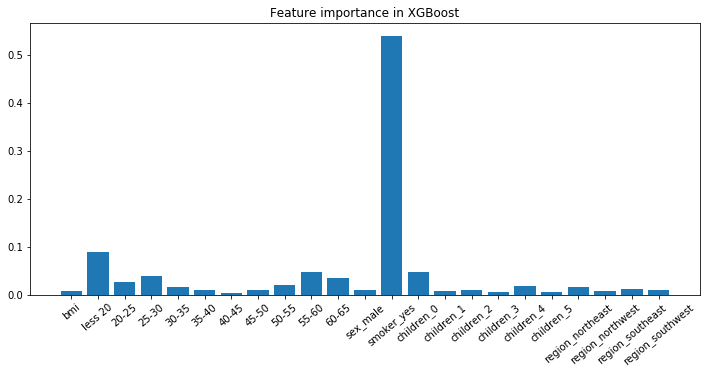

In [45]:
plt.figure(figsize=(12, 5))
coef = xgb_best_estimator.feature_importances_
x = range(len(coef))

plt.bar(x, coef)
plt.xticks(x, X.columns, rotation=40)
plt.title('Feature importance in XGBoost')
plt.show()

In [46]:
xgb_regr_feature_importance = X.columns[np.argsort(xgb_best_estimator.feature_importances_)[::-1]]
pd.DataFrame(np.column_stack((lin_regr_feature_importance,
                              rf_regr_feature_importance,
                              sgd_regr_feature_importance,
                              xgb_regr_feature_importance)), columns=["lin regr",
                                                                      "rf regr",
                                                                      "sgd regr",
                                                                      "xgboost"])

,lin regr,rf regr,sgd regr,xgboost
0,smoker_yes,smoker_yes,smoker_yes,smoker_yes
1,less 20,less 20,region_northeast,less 20
2,20-25,20-25,region_northwest,children_0
3,60-65,bmi,region_southwest,55-60
4,25-30,25-30,children_4,25-30
5,55-60,30-35,region_southeast,60-65
6,50-55,60-65,children_5,20-25
7,30-35,children_0,children_2,50-55
8,children_4,55-60,60-65,children_4
9,children_0,50-55,55-60,30-35


#### CatBoost

In [47]:
cat_best_estimator, cat_best_params = search_best_hyperparams(CatBoostRegressor(loss_function='RMSE', 
                                                                        silent=True, iterations=100), 
                                                      params={'depth': range(5, 12),
                                                              'l2_leaf_reg': [0.1, 0.3, 0.7],
                                                              'bagging_temperature': [0., 0.5, 1, 2, 10]},
                                                      X_train=X_train)

In [48]:
print('best model:', cat_best_estimator)
print('best params for CatBoost:', cat_best_params)

# cat = CatBoostRegressor(loss_function='RMSE', silent=True, iterations=100)
print('Results of evaluating the best CatBoost')
errors_of_prediction(cat_best_estimator, X_test)

best model: <catboost.core.CatBoostRegressor object at 0x13800c710>
best params for CatBoost: {'l2_leaf_reg': 0.1, 'depth': 8, 'bagging_temperature': 0.0}
Results of evaluating the best CatBoost
MSE: 32644250.932311386
RMSE: 5713.514761712915
MAE: 3413.1876442254734
mean absolute relative_error: 34.51949566203397 %


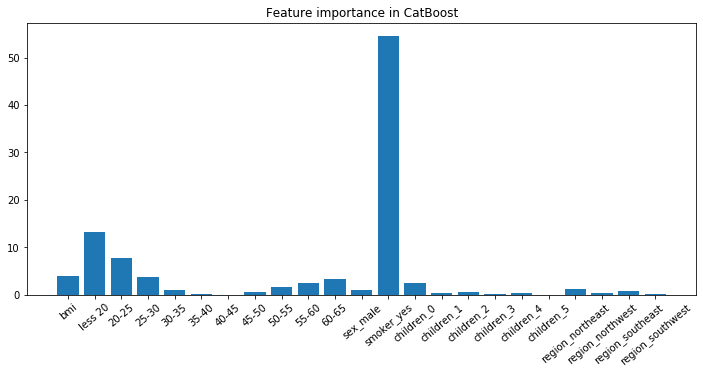

In [49]:
plt.figure(figsize=(12, 5))
coef = cat_best_estimator.feature_importances_
x = range(len(coef))

plt.bar(x, coef)
plt.xticks(x, X.columns, rotation=40)
plt.title('Feature importance in CatBoost')
plt.show()

In [50]:
cat_regr_feature_importance = X.columns[np.argsort(cat_best_estimator.feature_importances_)[::-1]]
pd.DataFrame(np.column_stack((lin_regr_feature_importance,
                              rf_regr_feature_importance,
                              sgd_regr_feature_importance,
                              xgb_regr_feature_importance,
                              cat_regr_feature_importance)), columns=["lin regr",
                                                                      "rf regr",
                                                                      "sgd regr",
                                                                      "xgboost",
                                                                      "catboost"])

,lin regr,rf regr,sgd regr,xgboost,catboost
0,smoker_yes,smoker_yes,smoker_yes,smoker_yes,smoker_yes
1,less 20,less 20,region_northeast,less 20,less 20
2,20-25,20-25,region_northwest,children_0,20-25
3,60-65,bmi,region_southwest,55-60,bmi
4,25-30,25-30,children_4,25-30,25-30
5,55-60,30-35,region_southeast,60-65,60-65
6,50-55,60-65,children_5,20-25,children_0
7,30-35,children_0,children_2,50-55,55-60
8,children_4,55-60,60-65,children_4,50-55
9,children_0,50-55,55-60,30-35,region_northeast


As we see, for linear regressor, random forest, xgboost, catboost the most important features are indicator whether the person smokes and also whether the age is less than 20 or not. Other age categories are also pretty high in the feature importance rate for these regressors. Radically different is stochastic gradient regressor's results, as 4 out of first 5 are categories, showing different regions. But still the binary feature whether a person is a smoker, still has high importance.

### Let's try simple approach - averaging results of different models

In [51]:
models = {
    'lin': LinearRegression().fit(X_train, y_train), 
    'sgd': sgd_best_estimator,
    'xgb': xgb_best_estimator,
    'cat': cat_best_estimator,
    'rf': rf_best_estimator,
}

def get_average_predictions(models):
    predictions = np.mean(np.column_stack([model.predict(X_test) for _, model in models.items()]), axis=1)
    return predictions

predictions = get_average_predictions(models)
compute_errors(y_test, predictions)

MSE: 32553221.458870977
RMSE: 5705.543046798523
MAE: 3330.0687459029737
mean absolute relative_error: 32.88693576917537 %


It already helped to improve the results and to reduce the error on a test set!

### Let's implement stacking now using RandomForest as meta regressor, and four others for making meta-features.

In [52]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True)
# list(kf.split(y_train))

def predict_meta_features(model, X_train):
    length = X_train.shape[0]
    
    meta_feature = pd.DataFrame(columns=['id', 'feat'])
    for train_index, test_index in kf.split(y_train):
#         print(X_train.values)
        model.fit(X_train.values[train_index], y_train.values[train_index])
        meta_feature = pd.concat((meta_feature, pd.DataFrame({'id': test_index, 
                                                 'feat': model.predict(X_train.values[test_index])})))
                                 
    meta_feature = meta_feature.sort_values(by='id')
        
    return meta_feature['feat']

In [53]:
models = {
    'lin': LinearRegression().fit(X_train, y_train), 
    'sgd': sgd_best_estimator,
    'xgb': xgb_best_estimator,
    'cat': cat_best_estimator,
}

In [54]:
X_train_meta = pd.DataFrame()
X_test_meta = pd.DataFrame()

out_of_fold_predictions = np.zeros((X_train.shape[0], len(models)))

fitted_models = [list() for _ in models]
for i, (name, model) in enumerate(models.items()):
    for train_index, holdout_index in kf.split(y_train):
#         instance = clone(model)
        fitted_models[i].append(model)
        model.fit(X_train.values[train_index], y_train.values[train_index])
        y_pred = model.predict(X_train.values[holdout_index])
        out_of_fold_predictions[holdout_index, i] = y_pred
# get_average_predictions(models)
        
meta_test = pd.DataFrame(
    np.column_stack([
            np.column_stack([model.predict(X_test.values) for model in models]).mean(axis=1)
            for models in fitted_models 
    ]))

meta = pd.DataFrame(out_of_fold_predictions)
meta.head()

,0,1,2,3
0,9.164062,9.134097,8.845683,9.034606
1,8.390242,8.451175,8.614441,8.743906
2,9.527565,9.474898,9.115048,9.211189
3,9.365928,9.342701,9.787013,9.321331
4,8.859265,8.883271,7.966942,8.884449


In [55]:
rf_best_estimator, rf_best_params = search_best_hyperparams(RandomForestRegressor(criterion='mse'), 
                                                      params={'n_estimators': range(10, 300, 10),
                                                              'max_depth': range(3, 12)},
                                                           X_train=meta)

print(rf_best_estimator)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [56]:
errors_of_prediction(rf_best_estimator, meta_test)

MSE: 31262920.99329023
RMSE: 5591.325513086341
MAE: 3171.3311503951672
mean absolute relative_error: 31.534178109953857 %


### Such approach helped to improve the final score.
#### Now let's finally check the quality on the validation set, that wasn't used before for comparing models:

In [57]:
meta_val = pd.DataFrame(
    np.column_stack([
            np.column_stack([model.predict(X_val.values) for model in models]).mean(axis=1)
            for models in fitted_models 
    ]))

errors_of_prediction(rf_best_estimator, meta_val, y_test=y_val)

MSE: 21086338.98301336
RMSE: 4591.986387503055
MAE: 2602.7088554787397
mean absolute relative_error: 25.995067634518573 %
